# Import from Database and Analysis
This notebook imports shared Craigslist listings from the database on Istanbul for initial data exploration and analysis.

In [202]:
#import packages
import pandas as pd
import numpy as np
import re as re
import json    # library for working with JSON-formatted text strings
import requests  # library for accessing content from web URLs
import pprint  # library for making Python data structures readable
import psycopg2
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import plotly as py
from plotly.graph_objs import *
pp = pprint.PrettyPrinter()
pd.options.mode.chained_assignment = None #disables warnings for editing copy of a dataframe
pd.set_option('display.float_format', lambda x: '%.3f' % x) #describe() vars are not in scientific notation
pd.set_option('max_columns', 30)
%matplotlib inline

In [203]:
# Defining font styles for graphics
family = 'Arial'
title_font = fm.FontProperties(family=family, style='normal', size=18, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=14, weight='normal', stretch='normal')

In [204]:
# Creating function for defining colors for graphics
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

In [205]:
# Read in credentials from private settings file
with open('settings.json') as settings_file:    
    settings = json.load(settings_file)

In [206]:
#try to connect to database on local machine
dbname = settings['dbname']
user = settings['user']
host = settings['host']
password = settings['password']

conn_str = "dbname = {0} user = {1} host = {2} password = {3}".format(dbname, user, host, password)

try:
    conn = psycopg2.connect(conn_str)
except:
    print ("I am unable to connect to the database")

In [207]:
# example dataframe with all the listings (as of 04/24, about 23k listings)
df = pd.read_sql_query("select * from shared_listings;",con=conn)

In [208]:
df.shape

(143214, 23)

### Example SQL pulls

In [ ]:
# example syntax for pulling just those from newyork domain
df_nyc = pd.read_sql_query("select * from shared_listings where region = 'newyork';",con=conn)

In [ ]:
# example syntax for pulling just those on a specific date (April 22)
df_april25 = pd.read_sql_query("select * from shared_listings where dt >= '2017-04-25' AND dt < '2017-04-23';",con=conn)

In [ ]:
# example syntax for pulling just those on a specific date (April 22)
df_april25 = pd.read_sql_query("select * from shared_listings where dt >= '2017-04-25';",con=conn)

In [ ]:
df_april24 = pd.read_sql_query("select * from shared_listings where dt >= '2017-04-24'AND dt < '2017-04-25';",con=conn)

In [ ]:
df_april23 = pd.read_sql_query("select * from shared_listings where dt >= '2017-04-23'AND dt < '2017-04-24';",con=conn)

In [ ]:
#close database connection (no longer needed)
conn.close()

### De-Duplication

In [209]:
df.loc[df.lat == 99, 'lat'] = 0
df.loc[df.lng == 99, 'lng'] = 0
df.loc[df.sqft == 0, 'sqft'] = np.nan

#For any duplicate post, we want to keep the version with the most information. Therefore, assign a score to each post and 
#give one point for square footage, lat, long and price

df['price_exists'] = df['rent']>0
df['sqft_exists'] = df['sqft']>0
df['lat_exists'] = df['lat']>0
df['lng_exists'] = df['lng']<0
df['score'] = df[['price_exists','sqft_exists','lat_exists','lng_exists']].astype(bool).sum(axis=1)

In [210]:
#Sort rows by score
df = df.sort_values(by='score',ascending=False)

In [211]:
dedupe1 = pd.DataFrame(df.drop_duplicates(subset='pid', inplace=False))

In [212]:
dedupe1.shape

(108794, 28)

In [213]:
dedupe2 = pd.DataFrame(dedupe1.drop_duplicates(subset='body_text', inplace=False))

In [214]:
dedupe2.shape

(84484, 28)

### Quick bar chart to see impact of deduplication on sample size

In [215]:
y = [len(df),len(dedupe1), len(dedupe2)]
labels = ['original', 'dedupe_pid', 'dedupe_body']
x = [1,2,3]

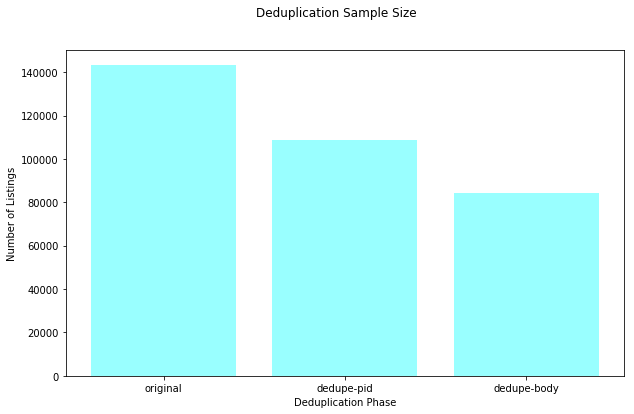

In [216]:
plt.figure(figsize=(10,6) )
plt.suptitle('Deduplication Sample Size')
plt.xlabel('Deduplication Phase')
plt.ylabel('Number of Listings')
plt.xticks(x, labels)
ax = plt.bar(x, y, alpha=.4, color='cyan', align='center')
plt.show()

#### Code for plotting same histo w/Plotly

In [29]:
#For initializing offline mode. Not working though...
#py.offline.init_notebook_mode() 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [217]:
data = [Bar(x=['original','dedupe_pid','dedupe_body'], y=[len(df),len(dedupe1), len(dedupe2)])]
py.offline.plot(data)

'file://C:\\Users\\james\\Documents\\Berkeley_Docs\\Spring_17_Courses\\CP290 Data Lab\\Database\\temp-plot.html'

### More Filtering

In [218]:
# Filtering out listings that don't include rent price
unique_wprice = dedupe2[dedupe2['rent'] > 0]

In [219]:
unique_wprice.shape

(70773, 28)

In [220]:
# in this cell, define the values by which we will filter the 3 columns. This will vary depending on the sample we're looking at. 
upper_percentile = 0.997
lower_percentile = 0.08

# how many rows would be within the upper and lower percentiles?
upper = int(len(unique_wprice) * upper_percentile)
lower = int(len(unique_wprice) * lower_percentile)

# get the rent values at the upper and lower percentiles
rent_sorted = unique_wprice['rent'].sort_values(ascending=True, inplace=False)
upper_rent = rent_sorted.iloc[upper]
lower_rent = rent_sorted.iloc[lower]

# get the sqft values at the upper and lower percentiles
sqft_sorted = unique_wprice['sqft'].sort_values(ascending=True, inplace=False)
upper_sqft = sqft_sorted.iloc[upper]
lower_sqft = sqft_sorted.iloc[lower]

print('valid rent range:', [lower_rent, upper_rent])
print('valid sqft range:', [lower_sqft, upper_sqft])

valid rent range: [300.0, 5600.0]
valid sqft range: [208.0, nan]


In [221]:
#Filtering out rows with unreasonable rent prices 
rent_mask = (unique_wprice['rent'] > lower_rent) & (unique_wprice['rent'] < upper_rent)

In [222]:
filtered_listings = pd.DataFrame(unique_wprice[rent_mask])

In [223]:
filtered_listings.shape

(64598, 28)

In [224]:
filtered_listings.dtypes

pid                           object
dt                    datetime64[ns]
day_of_week                    int64
url                           object
title                         object
rent                         float64
rent_sqft                    float64
neighb                        object
region                        object
sqft                         float64
lat                          float64
lng                          float64
accuracy                       int64
body_text                     object
furnished                       bool
laundry_known                   bool
laundry_onpremises              bool
laundry_inunit                  bool
room_known                      bool
private_room                    bool
bath_known                      bool
parking_known                   bool
onsite_parking                  bool
price_exists                    bool
sqft_exists                     bool
lat_exists                      bool
lng_exists                      bool
s

In [225]:
#Creating dataframe that only includes shared listings that are private rooms
filtered_private_only = filtered_listings[filtered_listings['private_room']==True]

filtered_private_only.shape

(62225, 28)

### Full Filtered Database Charts

In [233]:
listings_ratios = pd.DataFrame()

#Number of total shared listings for reach region before deduplication or filtering
listings_ratios['all_shared_listings'] = df['region'].value_counts()

listings_ratios['deduplicated_pid'] = dedupe1['region'].value_counts()

listings_ratios['deduplicated_text'] = dedupe2['region'].value_counts()

listings_ratios['duplicate_listings'] = listings_ratios['all_shared_listings'] - listings_ratios['deduplicated_text'] 

listings_ratios['duplicate_ratio'] = listings_ratios['duplicate_listings']/listings_ratios['all_shared_listings']

listings_ratios['unique_ratio'] = listings_ratios['deduplicated_text']/listings_ratios['all_shared_listings']

In [234]:
listings_ratios.head()

,all_shared_listings,deduplicated_pid,deduplicated_text,duplicate_listings,duplicate_ratio,unique_ratio
newyork,22157,17029,9290,12867,0.581,0.419
sfbay,8203,6932,5867,2336,0.285,0.715
losangeles,7305,5811,4376,2929,0.401,0.599
washingtondc,7042,5544,4223,2819,0.400,0.600
boston,4289,3268,2504,1785,0.416,0.584


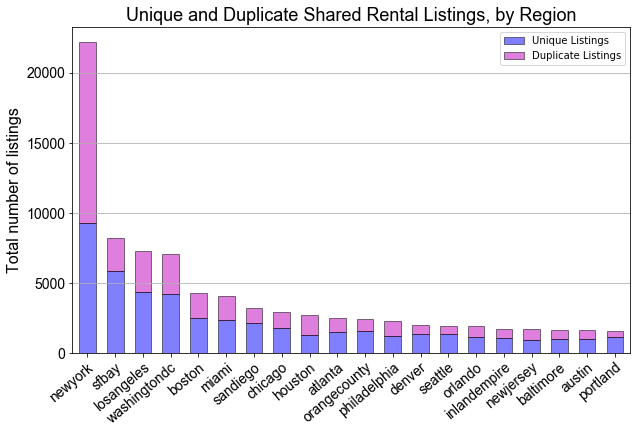

In [237]:
# plot the ratios of unique and duplicate listings, by region. This is before dropping observations without lat-lngs!

countdata = listings_ratios.sort_values(by='all_shared_listings', ascending=False)[['deduplicated_text','duplicate_listings']].head(20)
countdata.columns = ['Unique Listings', 'Duplicate Listings']
ax = countdata.plot(kind='bar',
                    stacked=True,
                    figsize=[10, 6], 
                    width=0.6, 
                    alpha=0.5, 
                    color=['b','m'],
                    edgecolor='k',
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(range(0, len(countdata)))
ax.set_xticklabels(countdata.index, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Unique and Duplicate Shared Rental Listings, by Region', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Total number of listings', fontproperties=label_font)        

#save_fig(plt.gcf(), 'count_unique_duplicate_listings.png')
plt.show()

## Spatial Join for Census Tracts

In [238]:
import geopandas as gpd

from geopandas import GeoDataFrame
from shapely.geometry import Point
from geopy.distance import great_circle

from scipy import ndimage

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = 10, 8
import fiona

### California Regions

In [239]:
california = gpd.read_file('ca_census_shapefile//cb_2015_06_tract_500k.shp')
print(type(california))
print(california.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'init': 'epsg:4269'}


In [240]:
#Use California CRS
# California.crs = {'init' :'epsg:2227'}
#http://spatialreference.org/ref/epsg/2227/
california_crs = {'init': 'epsg:2227'}
california = california.to_crs(california_crs)
print(california.crs)

{'init': 'epsg:2227'}


In [241]:
sfbay = filtered_private_only[filtered_private_only['region']=='sfbay']

In [242]:
sfbay = sfbay[sfbay.lat != 0]

In [243]:
los_angeles = filtered_private_only[filtered_private_only['region']=='losangeles']

In [244]:
los_angeles = los_angeles[los_angeles.lat != 0]

### LA GeoDF

In [245]:
geometryMapping_la = [Point(xy) for xy in zip(los_angeles.lng, los_angeles.lat)]
geo_la = GeoDataFrame(los_angeles, crs={'init' :'epsg:4326'}, geometry=geometryMapping_la)
geo_la=geo_la.to_crs(california_crs)
print(type(geo_la))
print(geo_la.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'init': 'epsg:2227'}


### SF GeoDF

In [246]:
geometryMapping = [Point(xy) for xy in zip(sfbay.lng, sfbay.lat)]
geo_sf = GeoDataFrame(sfbay, crs={'init' :'epsg:4326'}, geometry=geometryMapping)
geo_sf=geo_sf.to_crs(california_crs)
print(type(geo_sf))
print(geo_sf.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'init': 'epsg:2227'}


In [247]:
la_joined = gpd.sjoin(geo_la, california, how='inner', op='intersects')

In [248]:
sf_joined = gpd.sjoin(geo_sf, california, how="inner", op='intersects')

In [250]:
# Dropping unnecessary fields that came from Census shapefile
la_joined.drop(['ALAND','LSAD','NAME','AWATER','AFFGEOID','STATEFP','COUNTYFP'], axis=1, inplace=True)
sf_joined.drop(['ALAND','LSAD','NAME','AWATER','AFFGEOID','STATEFP','COUNTYFP'], axis=1, inplace=True)

### Mapping

In [ ]:
base = california.plot(color='gray', linewidth=.1)
sf_joined.plot(color='red', ax=base)
la_joined.plot(color='b', ax=base)
plt.show()

### Comparing Vacant to Shared Listings

In [251]:
vacant = pd.read_csv('vacant_april_listings.csv',dtype={'fips_block':str})

In [252]:
# Creating a GEOID field that's comparable to shared listings
vacant['GEOID'] = vacant['fips_block'].str[:-4]

In [253]:
# Turning studios into 1BRs for calculating rent per bedroom
vacant['beds2'] = vacant['beds']
vacant.loc[vacant.beds2 == 0, 'beds2'] = 1


In [254]:
vacant['rent_per_br'] = vacant['rent']/vacant['beds2']

In [255]:
# in this cell, define the values by which we will filter the 3 columns. This will vary depending on the sample we're looking at. 
upper_percentile = 0.99
lower_percentile = 0.01

# how many rows would be within the upper and lower percentiles?
upper = int(len(vacant) * upper_percentile)
lower = int(len(vacant) * lower_percentile)

# get the rent/sqft values at the upper and lower percentiles
rent_sqft_sorted = vacant['rent_sqft'].sort_values(ascending=True, inplace=False)
upper_rent_sqft = rent_sqft_sorted.iloc[upper]
lower_rent_sqft = rent_sqft_sorted.iloc[lower]

# get the rent values at the upper and lower percentiles
rent_sorted = vacant['rent'].sort_values(ascending=True, inplace=False)
upper_rent = rent_sorted.iloc[upper]
lower_rent = rent_sorted.iloc[lower]

# get the sqft values at the upper and lower percentiles
sqft_sorted = vacant['sqft'].sort_values(ascending=True, inplace=False)
upper_sqft = sqft_sorted.iloc[upper]
lower_sqft = sqft_sorted.iloc[lower]

print('valid rent_sqft range:', [lower_rent_sqft, upper_rent_sqft])
print('valid rent range:', [lower_rent, upper_rent])
print('valid sqft range:', [lower_sqft, upper_sqft])

valid rent_sqft range: [0.36067551266599995, 4.9182839632300004]
valid rent range: [425.0, 4890.0]
valid sqft range: [360.0, 2740.0]


In [256]:
#Filtering out rows with unreasonable rent prices 
rent_mask = (vacant['rent'] > lower_rent) & (vacant['rent'] < upper_rent)

In [257]:
filtered_vacant = pd.DataFrame(vacant[rent_mask])

In [258]:
# Snapshot of median prices for total sample
print('median rent for all vacant listings:', filtered_vacant['rent'].median())
print('median rent for all vacant Studio Units:',(filtered_vacant[filtered_vacant['beds']==0])['rent_per_br'].median())
print('median rent for all vacant 1BR Units:',(filtered_vacant[filtered_vacant['beds']==1])['rent_per_br'].median())

print('median rent per bedroom for all vacant listings:', filtered_vacant['rent_per_br'].median())
print('median rent per bedroom for all multi-bedroom vacant listings:', (filtered_vacant[filtered_vacant['beds'] > 1])['rent_per_br'].median())

median rent for all vacant listings: 1230.0
median rent for all vacant Studio Units: 1267.0
median rent for all vacant 1BR Units: 1101.0
median rent per bedroom for all vacant listings: 760.0
median rent per bedroom for all multi-bedroom vacant listings: 562.5


In [259]:
vacant_sfbay = vacant[vacant['region']=='sfbay']

In [260]:
vacant_sfbay.shape

(44285, 17)

In [261]:
# Note: If we apply a filter for individual regions, we'd probably want to adjust the parameters to account for the smaller 
# sample size and different market; for example, $5000 is not a super atypical price in the Bay Area, shouldn't be filtered out 
print('median rent for all SF vacant listings:', vacant_sfbay['rent'].median())
print('median rent for all SF vacant Studio Units:',(vacant_sfbay[vacant_sfbay['beds']==0])['rent_per_br'].median())
print('median rent for all SF vacant 1BR Units:',(vacant_sfbay[vacant_sfbay['beds']==1])['rent_per_br'].median())

print('median rent per bedroom for all SF vacant listings:', vacant_sfbay['rent_per_br'].median())
print('median rent per bedroom for all SF multi-bedroom vacant listings:', (vacant_sfbay[vacant_sfbay['beds'] > 1])['rent_per_br'].median())

median rent for all SF vacant listings: 2695.0
median rent for all SF vacant Studio Units: 2189.0
median rent for all SF vacant 1BR Units: 2330.0
median rent per bedroom for all SF vacant listings: 1757.0
median rent per bedroom for all SF multi-bedroom vacant listings: 1375.0


In [265]:
print('median rent for room in SF shared listing:', sf_joined['rent'].median())

median rent for room in SF shared listing: 1100.0


In [266]:
vacant_la = vacant[vacant['region']=='losangeles']

In [ ]:
#vacant2 = vacant[(vacant['GEOID'] != '')]

In [269]:
# Grouping and aggragating by GEOID for vacant SF listings
sf_vacant_grouped = vacant_sfbay.groupby(by='GEOID')
sf_vacant_grouped = sf_vacant_grouped.agg({'rent_per_br':['mean','median','count']}).reset_index()

In [270]:
#Now, need to turn newly created multi-index dataframe into a single index dataframe 
sf_vacant_grouped.columns = sf_vacant_grouped.columns.get_level_values(1)

sf_vacant_grouped.columns = ['GEOID','tract_mean','tract_median','tract_count']

In [271]:
sf_vacant_grouped.sort_values(by='tract_count', ascending=False)

,GEOID,tract_mean,tract_median,tract_count
834,06075061500,3317.241,3243.000,665
829,06075060700,3071.421,2804.500,530
1164,06085505009,1967.590,1645.000,451
1160,06085505001,2028.533,2050.000,333
1163,06085505008,2114.107,2340.000,333
1260,06085509105,2009.162,1703.500,311
1493,06097150612,1315.899,1184.000,308
312,06001450743,1713.719,1488.500,301
1255,06085508704,2044.098,1888.000,292
1150,06085504505,1553.527,1322.500,291


In [272]:
sf_shared_grouped = sf_joined.groupby(by='GEOID')
sf_shared_grouped = sf_shared_grouped.agg({'rent':['mean','median','count']}).reset_index()

In [273]:
#Now, need to turn newly created multi-index 
sf_shared_grouped.columns = sf_shared_grouped.columns.get_level_values(1)

In [274]:
sf_shared_grouped.columns = ['GEOID','tract_mean','tract_median','tract_count']

In [275]:
sf_shared_grouped.sort_values(by='tract_count', ascending=False)

,GEOID,tract_mean,tract_median,tract_count
481,06075022901,1130.377,1000.000,53
565,06075061500,1823.615,1750.000,39
677,06081611900,1040.000,1050.000,33
401,06075011700,917.759,880.000,29
453,06075017802,1544.345,1400.000,29
503,06075026100,962.857,1050.000,28
560,06075060700,1812.593,1700.000,27
120,06001425104,1079.296,1000.000,27
412,06075012402,1122.538,1160.000,26
102,06001422800,1049.720,995.000,25


### SF Comparison

In [289]:
# Merging shared and vacant listings on GEOID
sf_compare=pd.merge(sf_shared_grouped,sf_vacant_grouped,how='outer',on='GEOID')

In [290]:
sf_compare.sort_values(by='tract_count_x', ascending=False).head()

,GEOID,tract_mean_x,tract_median_x,tract_count_x,tract_mean_y,tract_median_y,tract_count_y
481,06075022901,1130.377,1000.000,53.000,2485.296,2631.667,38.000
565,06075061500,1823.615,1750.000,39.000,3317.241,3243.000,665.000
677,06081611900,1040.000,1050.000,33.000,1457.983,1497.500,49.000
401,06075011700,917.759,880.000,29.000,3098.036,3095.000,14.000
453,06075017802,1544.345,1400.000,29.000,2637.528,2543.250,204.000


In [291]:
# Converting NaNs to 0s
#sf_compare = sf_compare.fillna(0)

In [292]:
# Creating column that calculates difference between tract medians for vacant and shared listings
sf_compare['difference'] = sf_compare['tract_median_y'] - sf_compare['tract_median_x']

In [293]:
# Sorting by tracts with most shared listings
sf_compare.sort_values(by='tract_count_x', ascending=False)

,GEOID,tract_mean_x,tract_median_x,tract_count_x,tract_mean_y,tract_median_y,tract_count_y,difference
481,06075022901,1130.377,1000.000,53.000,2485.296,2631.667,38.000,1631.667
565,06075061500,1823.615,1750.000,39.000,3317.241,3243.000,665.000,1493.000
677,06081611900,1040.000,1050.000,33.000,1457.983,1497.500,49.000,447.500
401,06075011700,917.759,880.000,29.000,3098.036,3095.000,14.000,2215.000
453,06075017802,1544.345,1400.000,29.000,2637.528,2543.250,204.000,1143.250
503,06075026100,962.857,1050.000,28.000,1253.611,1133.333,12.000,83.333
560,06075060700,1812.593,1700.000,27.000,3071.421,2804.500,530.000,1104.500
120,06001425104,1079.296,1000.000,27.000,1795.482,1747.500,167.000,747.500
412,06075012402,1122.538,1160.000,26.000,2985.488,3300.000,100.000,2140.000
102,06001422800,1049.720,995.000,25.000,2614.975,2016.000,67.000,1021.000


In [294]:
sf_compare.dtypes

GEOID              object
tract_mean_x      float64
tract_median_x    float64
tract_count_x     float64
tract_mean_y      float64
tract_median_y    float64
tract_count_y     float64
difference        float64
dtype: object

In [287]:
# Necessary to keep lead '0' in GEOID column when exported to .csv
sf_compare.GEOID = sf_compare.GEOID.apply('="{}"'.format)

In [295]:
sf_compare.to_csv('sf_compare2.csv')

## Visualz

In [178]:
listings_ratios['all_vacant_listings'] = vacant['region'].value_counts()
listings_ratios['shared_to_vacant_ratio'] = listings_ratios['deduplicated_pid']/listings_ratios['all_vacant_listings']

In [179]:
listings_ratios.head()

,all_shared_listings,deduplicated_text,deduplicated_pid,duplicate_listings,duplicate_ratio,unique_ratio,all_vacant_listings,shared_to_vacant_ratio
newyork,18831,8504.000,8348.000,10483.000,0.557,0.443,10993.000,0.759
sfbay,6883,5301.000,5163.000,1720.000,0.250,0.750,44285.000,0.117
losangeles,6221,3987.000,3862.000,2359.000,0.379,0.621,44792.000,0.086
washingtondc,5928,3860.000,3775.000,2153.000,0.363,0.637,57007.000,0.066
boston,3598,2338.000,2249.000,1349.000,0.375,0.625,8396.000,0.268


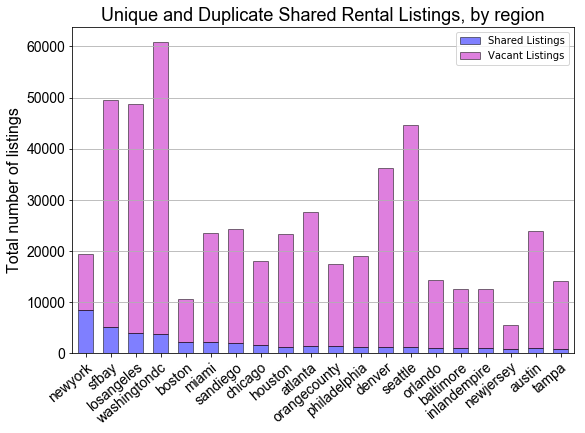

In [180]:
# plot the ratios of shared and vacant listings, by region
countdata = listings_ratios.sort_values(by='all_shared_listings', ascending=False)[['deduplicated_pid','all_vacant_listings']].head(20)
countdata.columns = ['Shared Listings', 'Vacant Listings']
ax = countdata.plot(kind='bar',
                    stacked=True,
                    figsize=[9, 6], 
                    width=0.6, 
                    alpha=0.5, 
                    color=['b','m'],
                    edgecolor='k',
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(range(0, len(countdata)))
ax.set_xticklabels(countdata.index, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Unique and Duplicate Shared Rental Listings, by region', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Total number of listings', fontproperties=label_font)        

#save_fig(plt.gcf(), 'count_unique_duplicate_listings.png')
plt.show()